# EDA/Comparison of GRNs (TDR119) - (across cell-types and across timepoints)


## Goals

- (1) perform EDA on GRNs from TDR119 (visualization - overlay two GRNs on top of each other using some anchor nodes, etc.)
- (2) comparison of GRNs (same cell-type, across timepoints) to see which "node/gene" has the most dynamic feature? how related is it to the gene expression profiles?
- (3) 

In [1]:
# load the libraries
#import copy
import glob
import time
import os
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.auto import tqdm

import celloracle as co
from celloracle.applications import Pseudotime_calculator
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [2]:
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams["savefig.dpi"] = 600
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# suppress warning messages regarding the pdf saving
import logging
logging.getLogger('fontTools').setLevel(logging.ERROR)

In [3]:
# Load the Links object (all GRNs, all cell-types, both filtered and unfiltered)
Links_TDR119 = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links")
Links_TDR119

In [4]:
# Load the Links object (all GRNs, all cell-types, both filtered and unfiltered)
Links_TDR118 = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/08_TDR118_celltype_GRNs.celloracle.links")
Links_TDR118

In [18]:
# Load the Links object (all GRNs, all cell-types, both filtered and unfiltered)
Links_TDR124 = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR124_cicero_output/08_TDR124_celltype_GRNs.celloracle.links")
Links_TDR124

Links_TDR125 = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/08_TDR125_celltype_GRNs.celloracle.links")
Links_TDR125

## Step 1. visualization of GRNs - networkX

- We will use networkX to visualize GRNs, especially will try to overlay two GRNs (either cell-types or different timepoints) to compare them visually.

In [23]:
# import networkx as nx

# # Sample data for network 1
# data1 = {
#     'source': ['GeneA', 'GeneB', 'GeneC', 'GeneD', 'GeneE'],
#     'target': ['GeneB', 'GeneC', 'GeneD', 'GeneE', 'GeneA'],
#     'edge_widths': [0.1, 0.2, 0.3, 0.4, 0.5]
# }
# df1 = pd.DataFrame(data1)

# # Sample data for network 2
# data2 = {
#     'source': ['GeneF', 'GeneG', 'GeneH', 'GeneA', 'GeneB'],
#     'target': ['GeneG', 'GeneH', 'GeneF', 'GeneB', 'GeneC'],
#     'edge_widths': [0.5, 0.4, 0.3, 0.2, 0.1]
# }
# df2 = pd.DataFrame(data2)

# # Create NetworkX graphs
# G1 = nx.from_pandas_edgelist(df1, 'source', 'target', ['edge_widths'])
# G2 = nx.from_pandas_edgelist(df2, 'source', 'target', ['edge_widths'])

# # Get positions of nodes in G1
# pos = nx.spring_layout(G1)

# # Draw G1
# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# nx.draw(G1, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, width=list(nx.get_edge_attributes(G1, 'edge_widths').values()))

# # Draw G2 using the same positions for common nodes
# plt.subplot(122)
# nx.draw(G2, pos, with_labels=True, node_size=700, node_color='lightgreen', font_size=10, width=list(nx.get_edge_attributes(G2, 'edge_widths').values()))

# plt.show()

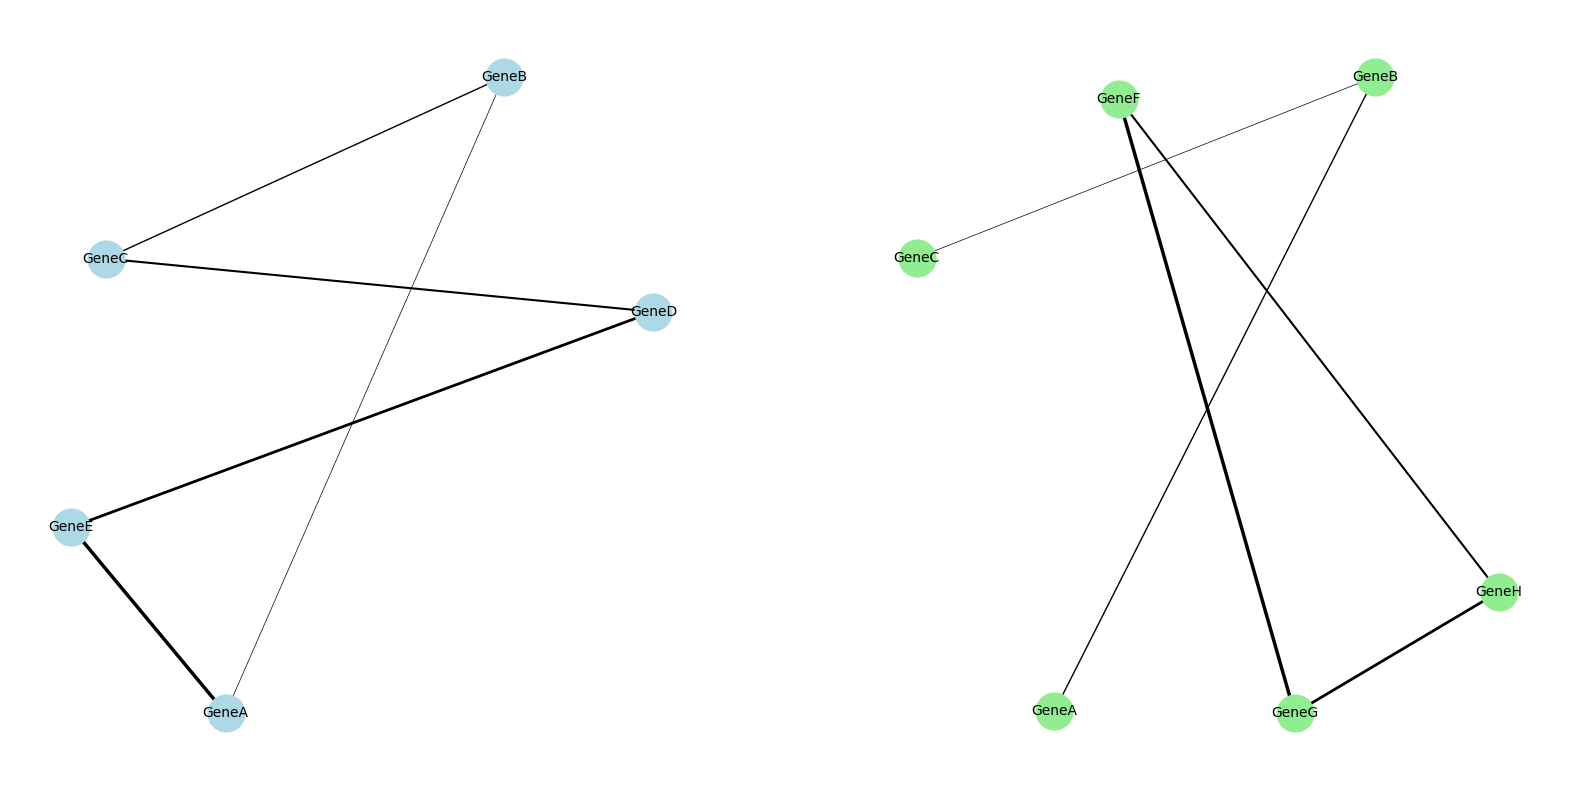

In [9]:
# Sample data for network 1
data1 = {
    'source': ['GeneA', 'GeneB', 'GeneC', 'GeneD', 'GeneE'],
    'target': ['GeneB', 'GeneC', 'GeneD', 'GeneE', 'GeneA'],
    'edge_widths': [0.1, 0.2, 0.3, 0.4, 0.5]
}
df1 = pd.DataFrame(data1)

# Sample data for network 2
data2 = {
    'source': ['GeneF', 'GeneG', 'GeneH', 'GeneA', 'GeneB'],
    'target': ['GeneG', 'GeneH', 'GeneF', 'GeneB', 'GeneC'],
    'edge_widths': [0.5, 0.4, 0.3, 0.2, 0.1]
}
df2 = pd.DataFrame(data2)

# Create NetworkX graphs
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', edge_attr='edge_widths')
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', edge_attr='edge_widths')

# Combine all unique nodes from both networks for a unified layout
all_nodes = set(df1['source']).union(df1['target']).union(df2['source']).union(df2['target'])
combined_graph = nx.Graph()
combined_graph.add_nodes_from(all_nodes)

# Compute the layout for the combined graph
pos = nx.spring_layout(combined_graph)

# Draw the first network
plt.figure(figsize=(20, 10)) # Increase figure size to have a clear view
plt.subplot(121)
nx.draw(G1, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, edge_color='black', width=[(G1[u][v]['edge_widths']*5) for u,v in G1.edges()])

# Draw the second network with shared positions
plt.subplot(122)
nx.draw(G2, pos, with_labels=True, node_size=700, node_color='lightgreen', font_size=10, edge_color='black', width=[(G2[u][v]['edge_widths']*5) for u,v in G2.edges()])

plt.show()

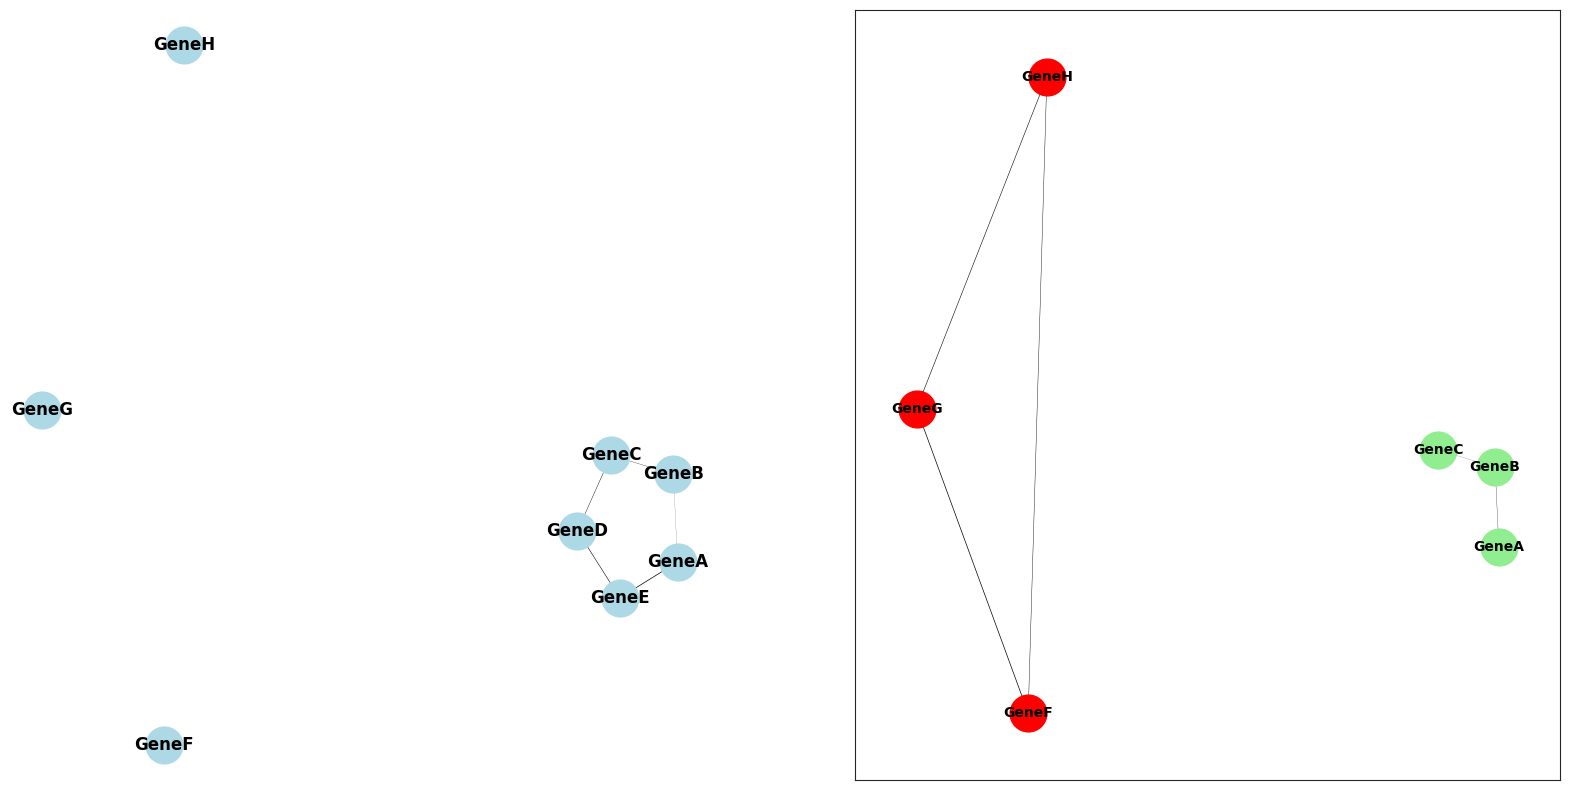

In [10]:
# Assume df1 and df2 are pandas DataFrames that contain your network data
# Create NetworkX graphs
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', edge_attr='edge_widths')
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', edge_attr='edge_widths')

# Find the shared nodes by intersection
shared_nodes = set(G1.nodes()).intersection(set(G2.nodes()))

# Make sure that G1 contains all nodes from G2 for position mapping
for node in G2.nodes():
    if node not in G1:
        G1.add_node(node)

# Compute positions for all nodes in G1
pos = nx.spring_layout(G1)  # You can choose other layout algorithms as well

# Now pos contains positions for all nodes in G1, including those only in G2
# When drawing G2, we only use positions for the nodes it contains
plt.figure(figsize=(20, 10))  # Large figure to avoid overlap

# Draw G1 - it includes all nodes so we can directly use 'pos'
plt.subplot(121)
nx.draw(G1, pos, with_labels=True, node_size=700, node_color='lightblue', font_weight='bold', width=list(nx.get_edge_attributes(G1, 'edge_widths').values()))

# Draw G2 - it will use the positions from G1 for shared nodes, ensuring they are aligned
plt.subplot(122)
nx.draw_networkx_nodes(G2, pos, nodelist=shared_nodes, node_size=700, node_color='lightgreen')  # Draw shared nodes first
nx.draw_networkx_nodes(G2, pos, nodelist=set(G2.nodes()) - shared_nodes, node_size=700, node_color='red')  # Draw unique nodes in red for distinction
nx.draw_networkx_edges(G2, pos, width=list(nx.get_edge_attributes(G2, 'edge_widths').values()))
nx.draw_networkx_labels(G2, pos, font_size=10, font_weight='bold')

# Show plot
plt.show()

In [21]:
celltype = "PSM"
df1 = Links_TDR119.filtered_links[celltype]
df2 = Links_TDR124.filtered_links[celltype]
df1

,source,target,coef_mean,coef_abs,p,-logp
165686,hmga1a,si:ch73-281n10.2,0.246583,0.246583,4.495863e-20,19.347187
153976,hmga1a,rpl7a,0.243075,0.243075,1.130211e-17,16.946841
171228,nfatc1,slit3,0.230074,0.230074,4.195092e-15,14.377259
79718,hmga1a,hmgb2b,0.132866,0.132866,2.085464e-18,17.680797
27756,sox3,cirbpa,0.129556,0.129556,2.494178e-16,15.603073
...,...,...,...,...,...,...
80030,hoxb3a,hmgn2,-0.015763,0.015763,2.240914e-07,6.649575
82788,rarga,hoxc3a,0.015759,0.015759,4.148930e-11,10.382064
140112,gli2a,pleca,0.015754,0.015754,5.426165e-08,7.265507
128212,cux2b,ntn1a,0.015737,0.015737,3.240248e-08,7.489422


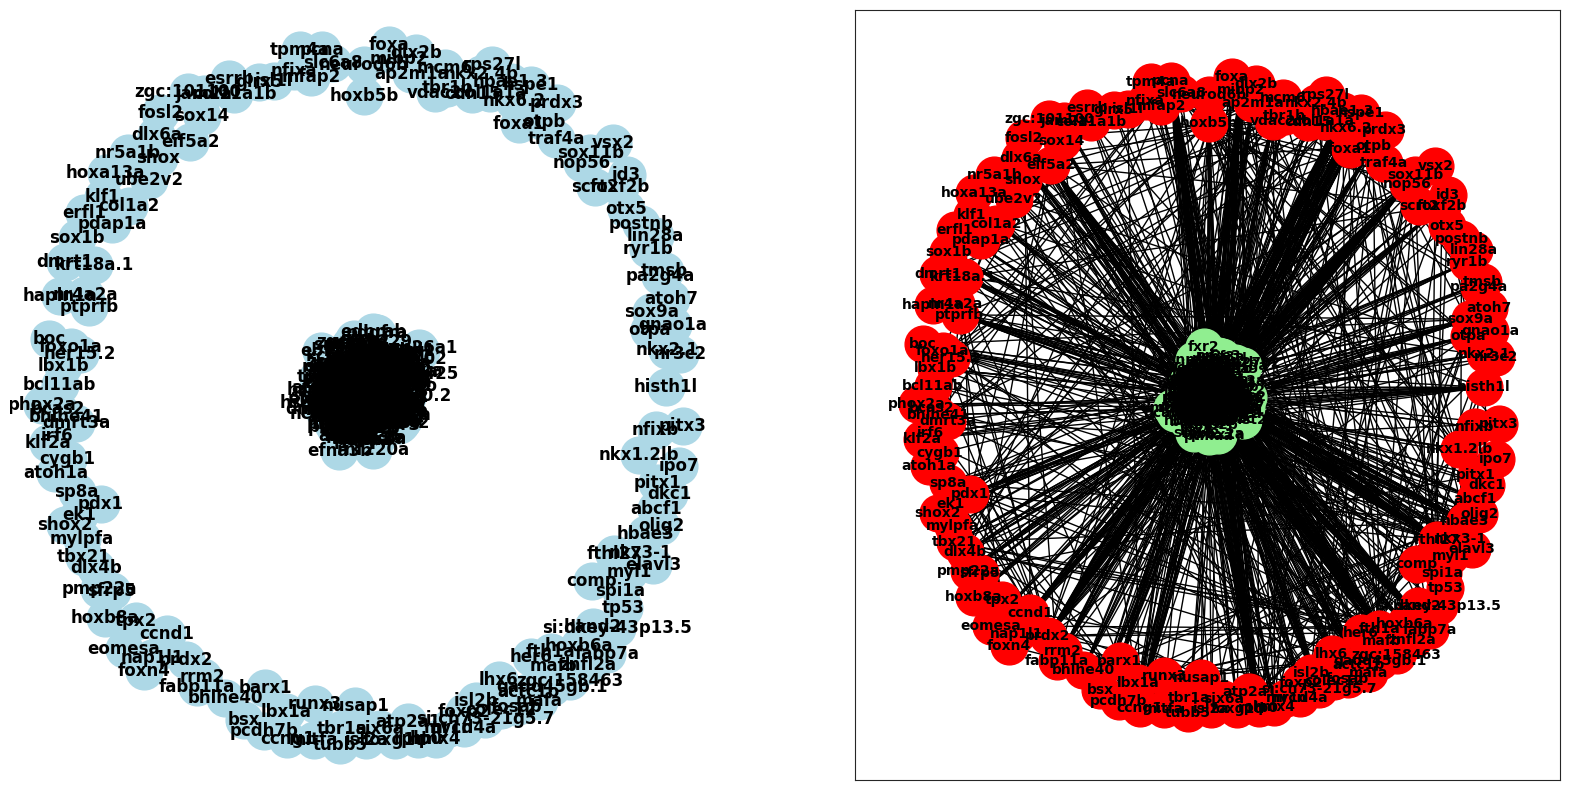

In [27]:
# Assume df1 and df2 are pandas DataFrames that contain your network data
# Create NetworkX graphs
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', edge_attr='coef_mean')
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', edge_attr='coef_mean')

# Find the shared nodes by intersection
shared_nodes = set(G1.nodes()).intersection(set(G2.nodes()))

# Make sure that G1 contains all nodes from G2 for position mapping
for node in G2.nodes():
    if node not in G1:
        G1.add_node(node)

# Compute positions for all nodes in G1
pos = nx.spring_layout(G1)  # You can choose other layout algorithms as well

# Now pos contains positions for all nodes in G1, including those only in G2
# When drawing G2, we only use positions for the nodes it contains
plt.figure(figsize=(20, 10))  # Large figure to avoid overlap

# Draw G1 - it includes all nodes so we can directly use 'pos'
plt.subplot(121)
nx.draw(G1, pos, with_labels=True, node_size=700, node_color='lightblue', font_weight='bold', width=list(nx.get_edge_attributes(G1, 'edge_widths').values()))

# Draw G2 - it will use the positions from G1 for shared nodes, ensuring they are aligned
plt.subplot(122)
nx.draw_networkx_nodes(G2, pos, nodelist=shared_nodes, node_size=700, node_color='lightgreen')  # Draw shared nodes first
nx.draw_networkx_nodes(G2, pos, nodelist=set(G2.nodes()) - shared_nodes, node_size=700, node_color='red')  # Draw unique nodes in red for distinction
nx.draw_networkx_edges(G2, pos, width=list(nx.get_edge_attributes(G2, 'edge_widths').values()))
nx.draw_networkx_labels(G2, pos, font_size=10, font_weight='bold')

# Show plot
plt.show()

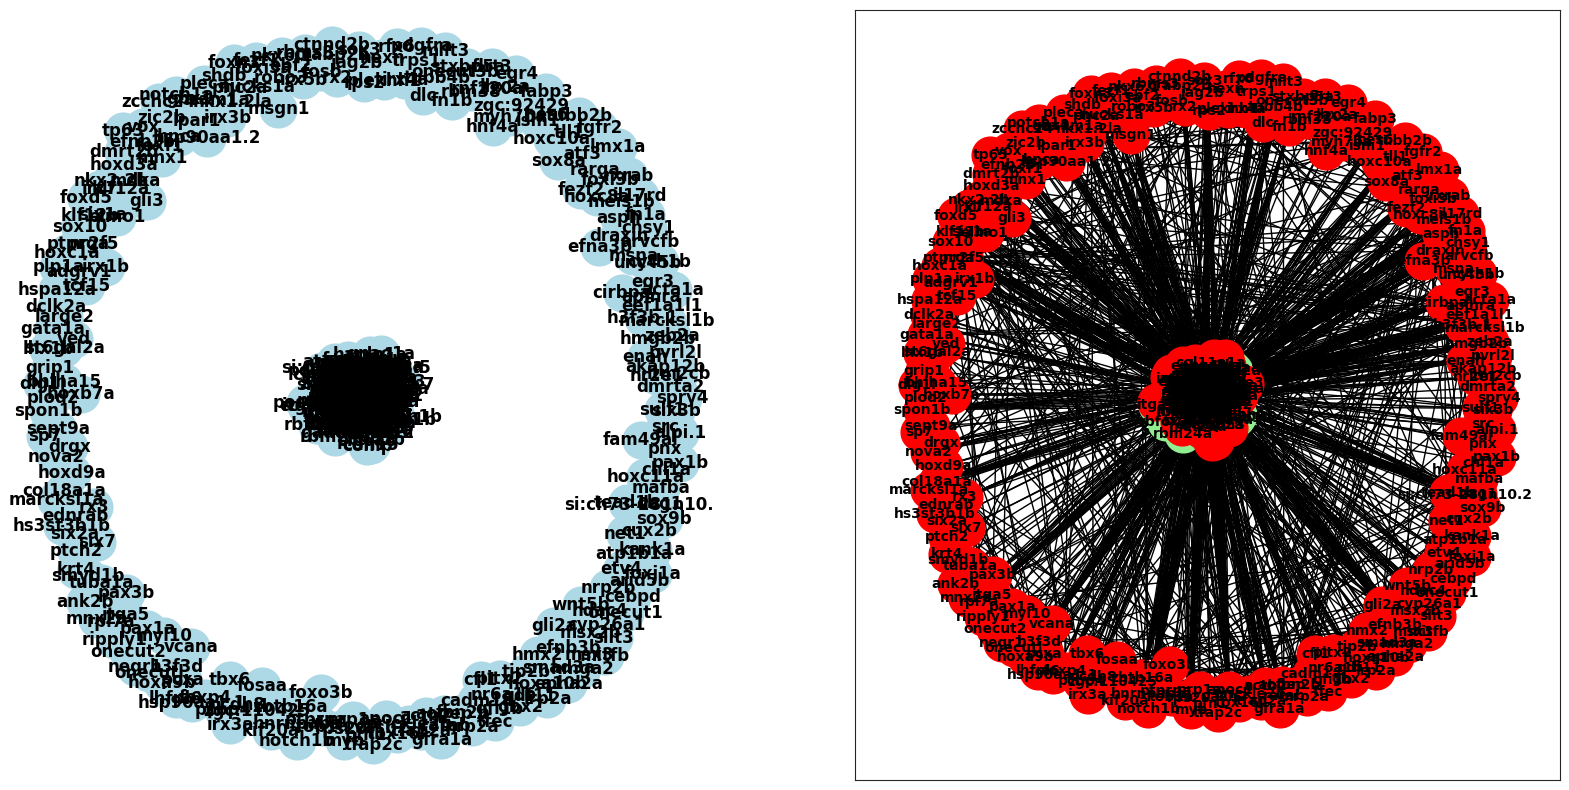

In [29]:
# Assume df1 and df2 are pandas DataFrames that contain your network data
# Create NetworkX graphs
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', edge_attr='coef_mean')
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', edge_attr='coef_mean')

# Find the shared nodes by intersection
shared_nodes = set(G1.nodes()).intersection(set(G2.nodes()))

# Make sure that G2 contains all nodes from G2 for position mapping
for node in G1.nodes():
    if node not in G2:
        G2.add_node(node)

# Compute positions for all nodes in G1
pos = nx.spring_layout(G2)  # You can choose other layout algorithms as well

# Now pos contains positions for all nodes in G1, including those only in G2
# When drawing G2, we only use positions for the nodes it contains
plt.figure(figsize=(20, 10))  # Large figure to avoid overlap

# Draw G2 - it includes all nodes so we can directly use 'pos'
plt.subplot(121)
nx.draw(G2, pos, with_labels=True, node_size=700, node_color='lightblue', font_weight='bold', width=list(nx.get_edge_attributes(G1, 'edge_widths').values()))

# Draw G1 - it will use the positions from G1 for shared nodes, ensuring they are aligned
plt.subplot(122)
nx.draw_networkx_nodes(G1, pos, nodelist=shared_nodes, node_size=700, node_color='lightgreen')  # Draw shared nodes first
nx.draw_networkx_nodes(G1, pos, nodelist=set(G2.nodes()) - shared_nodes, node_size=700, node_color='red')  # Draw unique nodes in red for distinction
nx.draw_networkx_edges(G1, pos, width=list(nx.get_edge_attributes(G2, 'edge_widths').values()))
nx.draw_networkx_labels(G1, pos, font_size=10, font_weight='bold')

# Show plot
plt.show()

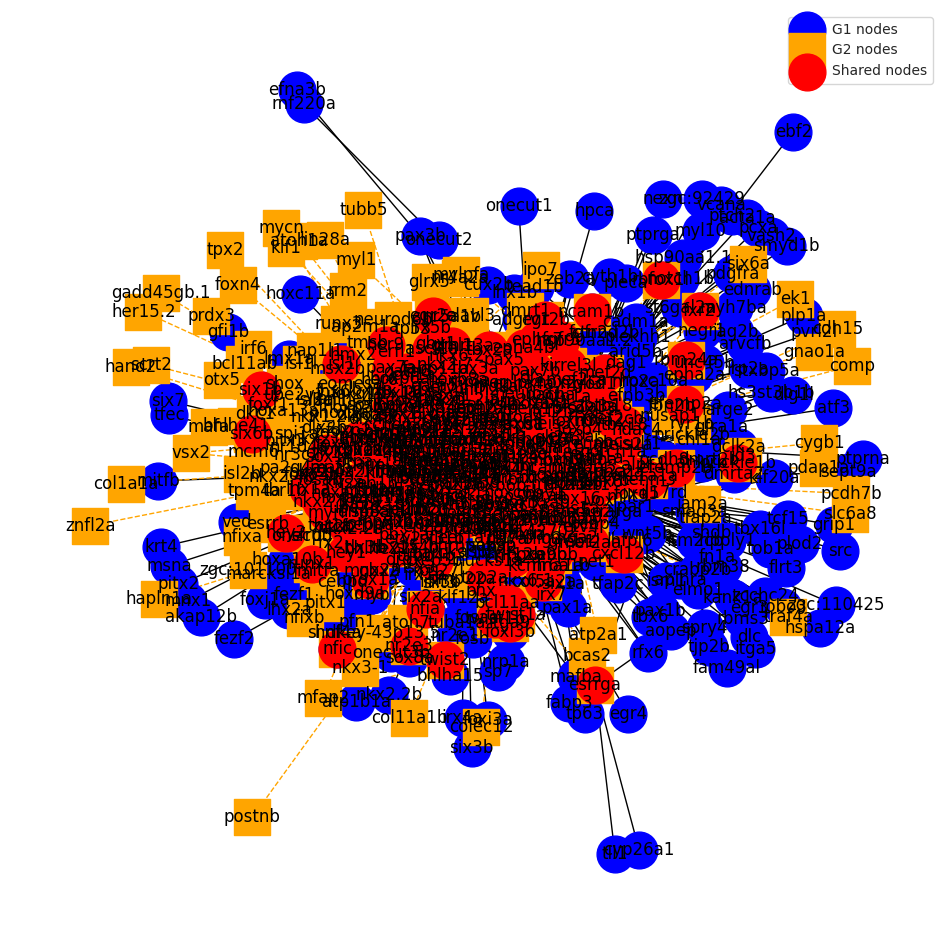

In [52]:
# Assume df1 and df2 are pandas DataFrames that contain your network data
# Create NetworkX graphs
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', edge_attr='coef_mean')
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', edge_attr='coef_mean')

# Combine all nodes and edges into a single graph for positioning
G_combined = nx.compose(G1, G2)  # This combines both graphs including all unique and shared nodes

# Compute positions for all nodes in the combined graph
pos = nx.spring_layout(G_combined)  # Use spring layout to position nodes

# Now pos has a position for every node in both G1 and G2

# Plotting starts here
plt.figure(figsize=(12, 12))

# Draw nodes for G1
nx.draw_networkx_nodes(G1, pos, node_size=700, node_color='blue', label='G1 nodes')

# Draw nodes for G2
nx.draw_networkx_nodes(G2, pos, node_size=700, node_color='orange', label='G2 nodes', node_shape='s')

# Draw shared nodes with a different color (e.g., red)
shared_nodes = set(G1.nodes()).intersection(G2.nodes())
nx.draw_networkx_nodes(G_combined, pos, nodelist=shared_nodes, node_size=700, node_color='red', label='Shared nodes')

# Draw all G1 edges
nx.draw_networkx_edges(G1, pos, edgelist=G1.edges(), width=1)

# Draw all G2 edges using a different style
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges(), width=1, edge_color='orange', style='dashed')

# Draw node labels if the graph is not too large
nx.draw_networkx_labels(G_combined, pos)

# Set legend and axis off, then show the plot
plt.legend()
plt.axis('off')
plt.show()

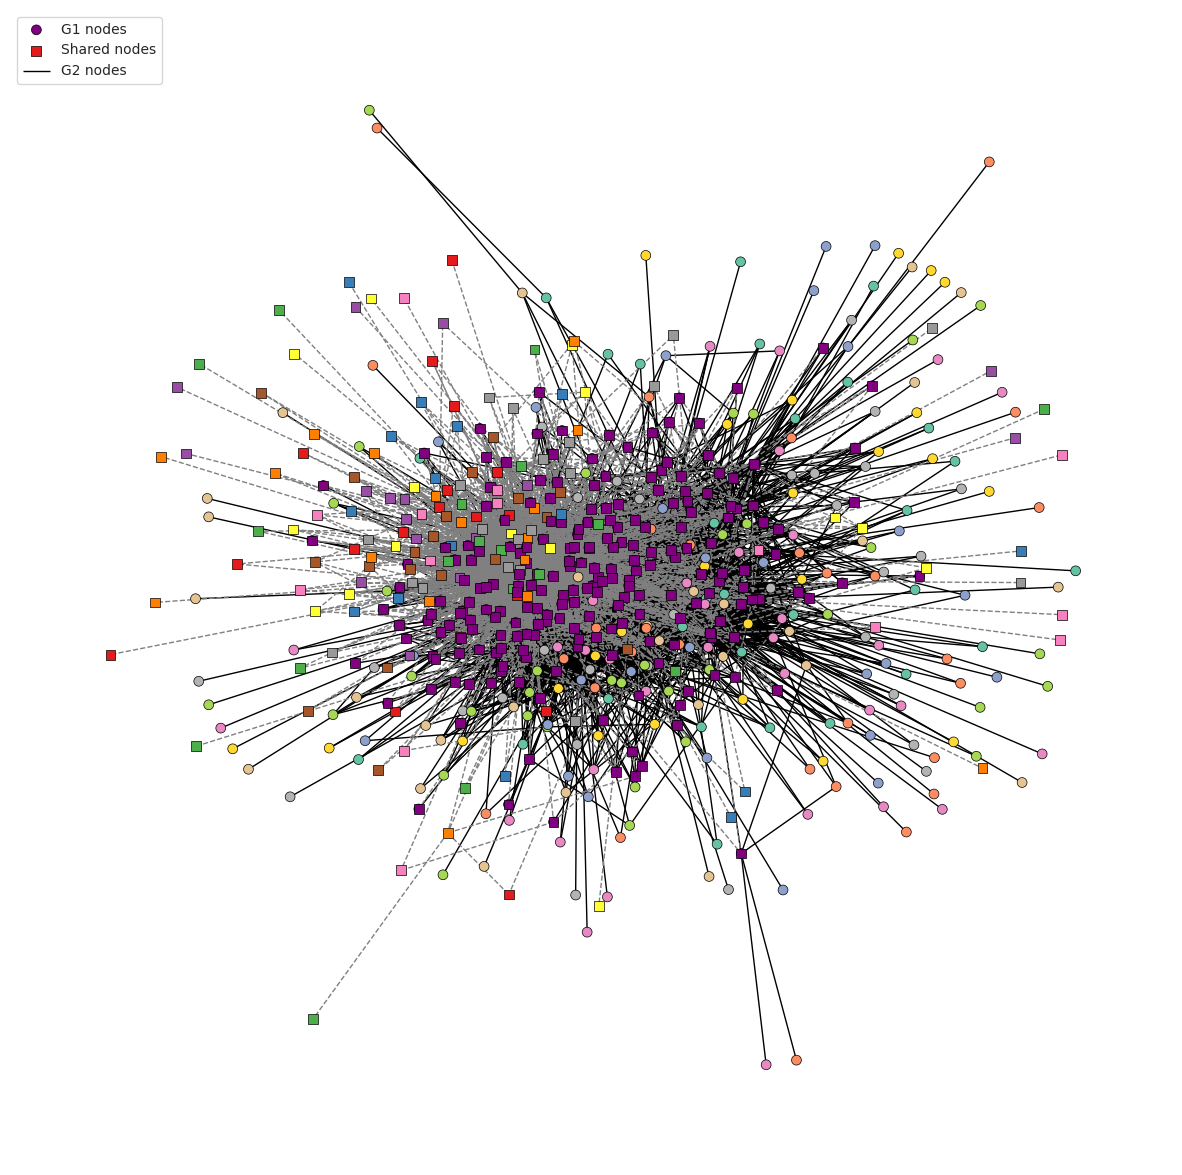

In [53]:
import seaborn as sns
# Use seaborn color palette
colors1 = sns.color_palette("Set2", len(G1.nodes))
colors2 = sns.color_palette("Set1", len(G2.nodes))

# Map each node to a color
node_colors1 = {node: colors1[idx] for idx, node in enumerate(G1.nodes())}
node_colors2 = {node: colors2[idx] for idx, node in enumerate(G2.nodes())}
shared_colors = {node: "purple" for node in set(G1.nodes()).intersection(G2.nodes())}

# Update the node color map with the shared nodes' colors
for node in shared_colors:
    node_colors1[node] = shared_colors[node]
    node_colors2[node] = shared_colors[node]

# Begin plotting
plt.figure(figsize=(15, 15))

# Draw G1 with its unique colors
nx.draw_networkx_nodes(G1, pos, node_color=[node_colors1[node] for node in G1.nodes()],
                       node_size=50, edgecolors='k', linewidths=0.5)

# Draw G2 with its unique colors
nx.draw_networkx_nodes(G2, pos, node_color=[node_colors2[node] for node in G2.nodes()],
                       node_size=50, edgecolors='k', linewidths=0.5, node_shape='s')

# Draw edges for both G1 and G2
nx.draw_networkx_edges(G1, pos, width=1)
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges(), width=1, edge_color='grey', style='dashed')

# Add node labels if the graph is not too dense to label clearly
# nx.draw_networkx_labels(G_combined, pos, font_size=7)

# Remove axis for a cleaner look
plt.axis('off')

# Show plot with a legend
plt.legend(['G1 nodes', 'Shared nodes', 'G2 nodes'], loc='upper left')
plt.show()

## Step 2. What are the unique "nodes" and "edges" for different timepoints?

- First, assess the unique "nodes" first. Note that this can be a result of (1) HVG filtering in scRNA-seq data, and/or (2) GRN filtering based on significance.
- Second, ...

In [69]:
sys.path.append("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/scripts/")
from module_network_topology_metrics import compute_corr_betwn_GRNs

In [70]:
GRN_15somites_score = Links_TDR119.merged_score
GRN_30somites_score = Links_TDR124.merged_score

In [83]:
def compute_corr_betwn_GRNs(df_GRN1, df_GRN2, 
                            celltype1, celltype2, network_metric,
                            make_plot=False):
    df1 = df_GRN1[df_GRN1.cluster==celltype1]
    df2 = df_GRN2[df_GRN2.cluster==celltype2]

    # Step 1. Get a union of gene_names
    gene_names = set(df1.index).union(df2.index)
    len(gene_names)

    # Step 2. Create a new dataframe with matching indices
    new_df1 = df1[df1.index.isin(gene_names)]
    new_df2 = df2[df2.index.isin(gene_names)]

    # Step 3. Fill missing values with 0
#     new_df1 = new_df1.reindex(gene_names, fill_value=0) #fill_value=0
#     new_df2 = new_df2.reindex(gene_names, fill_value=0)
    new_df1 = new_df1.reindex(gene_names)
    new_df2 = new_df2.reindex(gene_names)

    # Step 4. Create the zipped DataFrame
    zipped_df = pd.DataFrame({'metric_df1': new_df1[network_metric], 'metric_df2': new_df2[network_metric]})
    zipped_df
    
    # Compute the correlation coefficient
    corr = zipped_df.metric_df1.corr(zipped_df.metric_df2,
                                    method = "pearson")
    
    if make_plot==True:  
        # Step 5. Generate scatter plots, with Pearson correlation coeff.
        plt.scatter(x=zipped_df.metric_df1,
                    y=zipped_df.metric_df2)
        plt.xlabel("TDR118: "+ network_metric + "_" + celltype1)
        plt.ylabel("TDR119: "+ network_metric + "_" + celltype2)
        plt.title(network_metric)
        
        plt.annotate(f"Pearson Correlation: {corr:.2f}",
             xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)



    return corr

0.5657290190103335

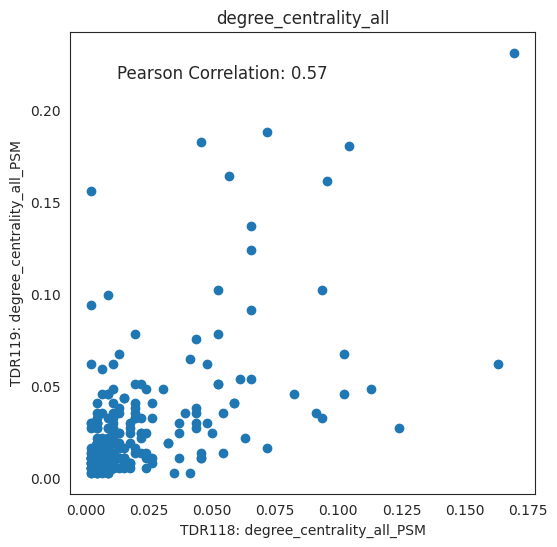

In [84]:
# with only overlapping genes (the unique genes were given NaN values)
compute_corr_betwn_GRNs(GRN_15somites_score, GRN_30somites_score, 
                               "PSM", "PSM", "degree_centrality_all",
                               make_plot=True)

0.27305614883259005

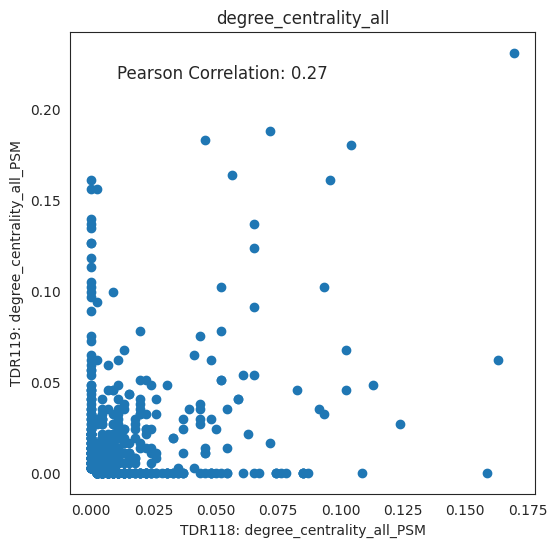

In [82]:
# with a union set of genes (the unique genes were given zero values)
compute_corr_betwn_GRNs(GRN_15somites_score, GRN_30somites_score, 
                               "PSM", "PSM", "degree_centrality_all",
                               make_plot=True)

### Step 2-1. degree_centrality_all

- This metric was used by Kamimoto et al., Cell Stem Cell, 2023. So, we will use this metric as our first-pass metric to compare the two GRNs.

In [85]:
# define the cell-types
celltypes = ['Adaxial_Cells', 'Differentiating_Neurons', 'Endoderm',
       'Epidermal', 'Lateral_Mesoderm', 'Muscle', 'NMPs',
       'Neural_Anterior', 'Neural_Crest', 'Neural_Posterior', 'Notochord',
       'PSM', 'Somites']

# define empty series to save the correlation coefficients
corr_same_celltypes =[]
corr_diff_celltypes = []


for ct1 in celltypes:
    for ct2 in celltypes:
        corr_coeff = compute_corr_betwn_GRNs(GRN_15somites_score, GRN_30somites_score, ct1, ct2, "degree_centrality_all")
        
        if ct1==ct2:
            corr_same_celltypes.append(corr_coeff)
        else:
            corr_diff_celltypes.append(corr_coeff)

In [86]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/GRN_comparison_timepoitns/"

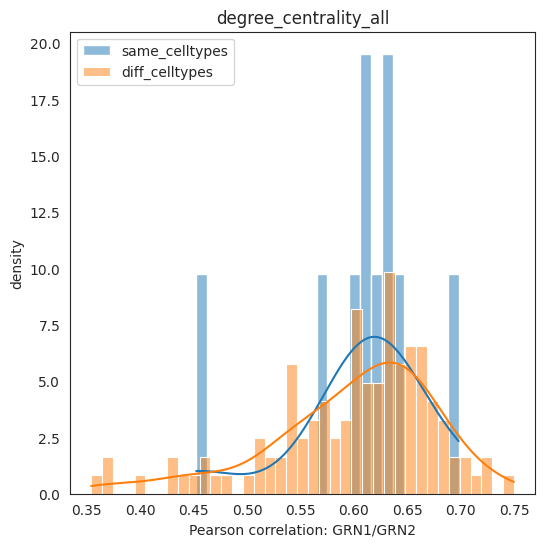

In [87]:
# define the bin width
bin_width = 0.01

# Calculate the number of bins for each histogram
num_bins1 = int((max(corr_same_celltypes) - min(corr_same_celltypes)) / bin_width)
num_bins2 = int((max(corr_diff_celltypes) - min(corr_diff_celltypes)) / bin_width)

plt.figure()
sns.histplot(corr_same_celltypes, kde=True, bins=num_bins1, stat="density", label='same_celltypes')
sns.histplot(corr_diff_celltypes, kde=True, bins=num_bins2, stat="density", label='diff_celltypes')
# plt.hist(corr_same_celltypes, density=True, bins=num_bins1)
# plt.hist(corr_diff_celltypes, density=True, bins=num_bins2)
plt.xlabel("Pearson correlation: GRN1/GRN2")
plt.ylabel("density")
plt.title("degree_centrality_all")
plt.legend()

#plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/network_plots_TDR118/QC_corr_centrality_TDR118_TDR119_allCelltypes.pdf")
plt.savefig(figpath + "QC_corr_centrality_all_TDR119_TDR124_allCelltypes.pdf")
plt.savefig(figpath + "QC_corr_centrality_all_TDR119_TDR124_allCelltypes.png")
plt.show()

In [94]:
# celltype
celltype = "PSM"

# subset the GRN scores for specific cell type
df1 = GRN_15somites_score[GRN_15somites_score.cluster==celltype]
df2 = GRN_30somites_score[GRN_30somites_score.cluster==celltype]

# sort the dataframe based on specific network topology parameters
df1_sorted = df1.sort_values("degree_centrality_all", ascending=False)
df2_sorted = df2.sort_values("degree_centrality_all", ascending=False)

In [102]:
print(df1_sorted[df1_sorted.index=="meox1"])
print(df2_sorted[df2_sorted.index=="meox1"])

       degree_all  degree_in  degree_out  clustering_coefficient  \
meox1          75         15          60                0.063984   

       clustering_coefficient_weighted  degree_centrality_all  \
meox1                         0.072273               0.163043   

       degree_centrality_in  degree_centrality_out  betweenness_centrality  \
meox1              0.032609               0.130435                    7541   

       closeness_centrality  eigenvector_centrality  page_rank  \
meox1              0.095917                0.537609   0.002969   

       assortative_coefficient  average_path_length  community_random_walk  \
meox1                -0.290862             0.085166                      1   

       module  connectivity  participation           role cluster  
meox1       3      4.067883       0.654235  Connector Hub     PSM  
       degree_all  degree_in  degree_out  clustering_coefficient  \
meox1          23          1          22                0.034632   

       clust

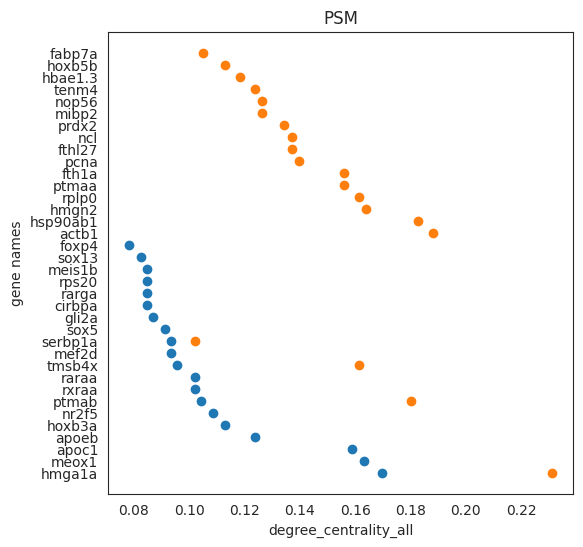

In [98]:
plt.scatter(df1_sorted[0:20].degree_centrality_all, df1_sorted[0:20].index)
plt.scatter(df2_sorted[0:20].degree_centrality_all, df2_sorted[0:20].index)

plt.title(celltype)
plt.xlabel("degree_centrality_all")
plt.ylabel("gene names")
plt.show()

In [38]:
celltype = "PSM"
df1 = Links_TDR119.filtered_links[celltype]
df2 = Links_TDR124.filtered_links[celltype]

print(df1)
print(df2)

        source            target  coef_mean  coef_abs             p      -logp
165686  hmga1a  si:ch73-281n10.2   0.246583  0.246583  4.495863e-20  19.347187
153976  hmga1a             rpl7a   0.243075  0.243075  1.130211e-17  16.946841
171228  nfatc1             slit3   0.230074  0.230074  4.195092e-15  14.377259
79718   hmga1a            hmgb2b   0.132866  0.132866  2.085464e-18  17.680797
27756     sox3            cirbpa   0.129556  0.129556  2.494178e-16  15.603073
...        ...               ...        ...       ...           ...        ...
80030   hoxb3a             hmgn2  -0.015763  0.015763  2.240914e-07   6.649575
82788    rarga            hoxc3a   0.015759  0.015759  4.148930e-11  10.382064
140112   gli2a             pleca   0.015754  0.015754  5.426165e-08   7.265507
128212   cux2b             ntn1a   0.015737  0.015737  3.240248e-08   7.489422
144363   msx1b         prickle2b  -0.015728  0.015728  4.761664e-15  14.322241

[2000 rows x 6 columns]
          source      targe

In [49]:
set(df1.source)

165686    hmga1a
153976    hmga1a
171228    nfatc1
79718     hmga1a
27756       sox3
           ...  
80030     hoxb3a
82788      rarga
140112     gli2a
128212     cux2b
144363     msx1b
Name: source, Length: 2000, dtype: object

In [41]:
set(df1.source) - set(df2.source)
# set(df2.source) - set(df1.source)

{'arid5b',
 'atf3',
 'bhlha15',
 'cebpd',
 'cux2b',
 'dmrt2b',
 'dmrta2',
 'drgx',
 'ebf2',
 'egr3',
 'egr4',
 'etv4',
 'fezf1',
 'fezf2',
 'fosaa',
 'fosb',
 'foxd5',
 'foxf1',
 'foxi3a',
 'foxi3b',
 'foxj1a',
 'foxn3',
 'foxo3b',
 'foxp4',
 'gata1a',
 'gbx1',
 'gbx2',
 'gfi1b',
 'gli2a',
 'gli3',
 'hmga2',
 'hmx2',
 'hnf4a',
 'hoxa10b',
 'hoxa9b',
 'hoxb7a',
 'hoxc10a',
 'hoxc11a',
 'hoxc1a',
 'hoxc8a',
 'hoxd3a',
 'hoxd9a',
 'irx1b',
 'irx3a',
 'irx3b',
 'irx4a',
 'irx5b',
 'irx7',
 'klf12a',
 'klf12b',
 'lhx1b',
 'lhx2a',
 'lmx1a',
 'mafba',
 'meis1b',
 'mitfb',
 'mnx1',
 'mnx2a',
 'msx2b',
 'msx3',
 'myb',
 'nkx1.2la',
 'nkx2.2b',
 'nkx6.1',
 'nr2e1',
 'nr2f5',
 'nr6a1b',
 'onecut1',
 'onecut2',
 'onecut3b',
 'onecutl',
 'pax1a',
 'pax1b',
 'pax3b',
 'pitx2',
 'pnx',
 'rarab',
 'rarga',
 'rfx6',
 'rx2',
 'rx3',
 'rxrab',
 'six1a',
 'six2a',
 'six3b',
 'six7',
 'smad3a',
 'sox10',
 'sox3',
 'sox8a',
 'sox9b',
 'sp7',
 'tead1b',
 'tfap2a',
 'tfap2c',
 'tfec',
 'tp63',
 'trps1',
 've

In [ ]:
sys.app